# Pipeline of the anomaly detection on the SKAB using combined Hotelling's ($T^2$) and Q (SPE) statistics based on the PCA

Details regarding the SKAB one can find in the [SKAB repository](https://github.com/waico/SKAB).

## Libraries importing

In [ ]:
# libraries importing
import sys
import warnings

import pandas as pd

sys.path.append("..")
from core.t2 import T2
from core.metrics import chp_score
from core.utils import load_skab, plot_results

warnings.filterwarnings("ignore", category=UserWarning)

## Data

In [ ]:
list_of_df, anomaly_free_df = load_skab()

## Method

### Method initialization

In [ ]:
# classifier initializing
t2 = T2(scaling=True, using_pca=True)

In [ ]:
# inference
predicted_outlier, predicted_cp = [], []
for df in list_of_df:
    X_train = df[:400].drop(["anomaly", "changepoint"], axis=1)

    # classifier fitting
    t2.fit(X_train)

    # results predicting
    t2.predict(
        df.drop(["anomaly", "changepoint"], axis=1),
        window_size=5,
        plot_fig=False,
    )
    prediction = pd.Series(
        ((t2.t2["T2"].values > t2.t2_ucl) | (t2.q["Q"] > t2.q_ucl)).astype(
            int
        ),
        index=df.index,
    ).fillna(0)

    # predicted outliers saving
    predicted_outlier.append(prediction)

    # predicted CPs saving
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

### Results visualization

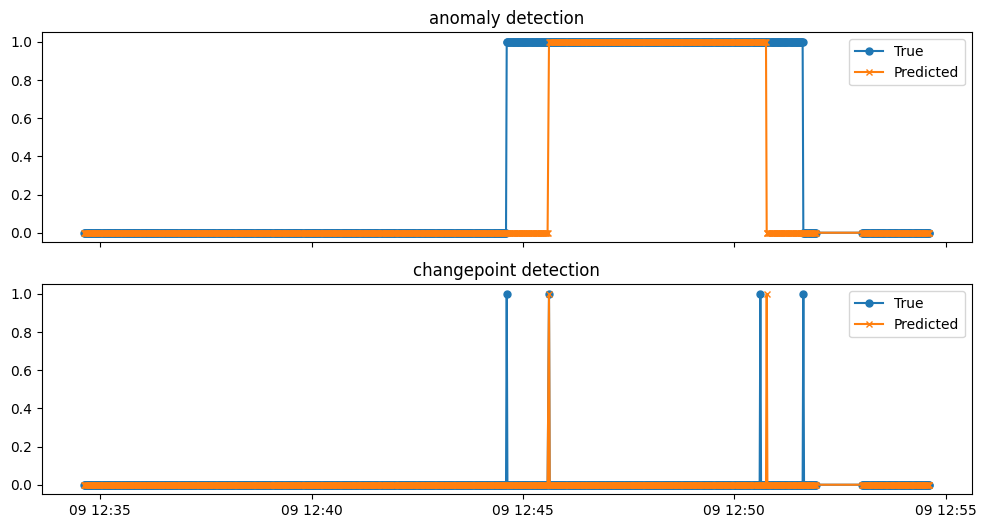

In [ ]:
# [donotremove]
true_outlier = [df.anomaly for df in list_of_df]
true_cp = [df.changepoint for df in list_of_df]
plot_results(
    (true_outlier[1], predicted_outlier[1]),
    (true_cp[1], predicted_cp[1]),
)

## Evaluation (metrics calculation)

### Binary classification (outlier detection) metrics

In [ ]:
# [donotremove]
# binary classification metrics calculation
binary = chp_score(true_outlier, predicted_outlier, metric="binary")

False Alarm Rate 12.09 %
Missing Alarm Rate 26.62 %
F1 metric 0.75


### Changepoint detection metrics

In [ ]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    predicted_cp,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 129
A number of missed CPs = 75
A number of FPs = 71
Average time 0 days 00:00:42.349074074


In [ ]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    predicted_cp,
    metric="nab",
    window_width="30S",
    anomaly_window_destination="center",
)

Standard  -  8.38
LowFP  -  -5.54
LowFN  -  15.66
